In [2]:
# Import the basics
import numpy as np

import matplotlib.pyplot as plt
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer
from qiskit.tools import visualization as qplt

import qiskit.providers.aer as aer
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator

# Import the noise model object
from qiskit.providers.aer.noise import NoiseModel

# Import all standard errors
from qiskit.providers.aer.noise.errors import *  

# Import noise base clases
from qiskit.providers.aer.noise.errors.quantum_error import QuantumError
from qiskit.providers.aer.noise.errors.readout_error import ReadoutError

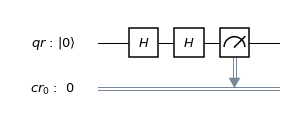

In [3]:
# Construct quantum circuit
qr = QuantumRegister(1, 'qr')
cr = ClassicalRegister(1, 'cr')
circ = QuantumCircuit(qr, cr)

N = 2;
for idx in range(N):
    circ.h(qr[0])

circ.measure(qr, cr)
circ.draw(output='mpl')

## Noise-Less model

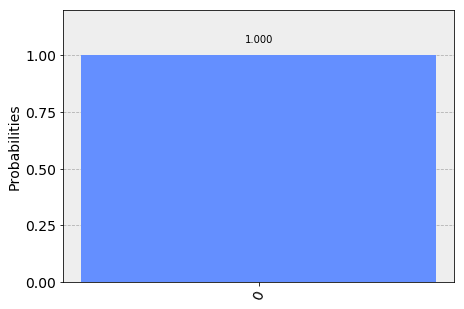

In [4]:
# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')
# Compile previous GHZ circuit using noise model basis gates
qobj = qiskit.compile(circ, simulator)

# Run the noisy simulation
result_bit_flip = simulator.run(qobj).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
qplt.plot_histogram(counts_bit_flip)

## Construct Noise

In [5]:
# Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.kron(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

NoiseModel:
  Instructions with noise: ['u2', 'u3', 'measure', 'reset', 'u1', 'cx']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


## Simulate with Noise

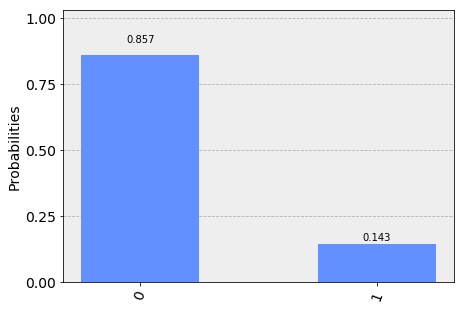

In [9]:
# Compile previous GHZ circuit using noise model basis gates
qobj = qiskit.compile(circ, simulator,
               basis_gates=noise_bit_flip.basis_gates)

# Run the noisy simulation
result_bit_flip = simulator.run(qobj, noise_model=noise_bit_flip).result()
counts_bit_flip = result_bit_flip.get_counts(0)


qplt.plot_histogram(counts_bit_flip)